### Training with the Rolling Window

The concept of this approach is to construct a model that achieves stable performance over time by maximizing the parameters of the sub-models used within it. In this case, a temporal window is employed, allowing for training and testing on a portion of the dataset rather than the entirety. Fundamentally, this approach aims to prioritize only the most recent data to enhance classification.

In [8]:
# import libraries and packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, make_scorer, classification_report


In [9]:
# This variable, if set to true, starts training models that require a long time, 
# therefore, it is recommended to keep it on False as the parameters will be taken 
# from the best ones of the last training.
training_models = False

# load data from dataset: EWS, STATIONARITY, DIFF_TIME
data = pd.read_excel('./FinancialMarketData.xlsx', sheet_name='EWS')
combined_data = pd.read_excel('./FinancialMarketData.xlsx', sheet_name='STATIONARITY')
combined_data = combined_data.drop(['Data', 'Y'], axis=1)
succ_data = pd.read_excel('./FinancialMarketData.xlsx', sheet_name='DIFF_TIME')
succ_data = succ_data.drop(['Data', 'Y'], axis=1)

print(succ_data)

flag = data['Y'].values
years = data['Data'].unique()
data = data.drop(['Data', 'Y'], axis=1)
data = pd.DataFrame(data)
data.head()

      XAU BGNL  XAU BGNL_Diff_Prec  XAU BGNL_Diff_Succ  XAU BGNL_Diff_PreSucc  \
0       287.65                4.40               -0.50                   3.90   
1       287.15               -0.50               -4.40                  -4.90   
2       282.75               -4.40               15.65                  11.25   
3       298.40               15.65                5.50                  21.15   
4       303.90                5.50                1.60                   7.10   
...        ...                 ...                 ...                    ...   
1104   1729.18               12.48               -1.22                  11.26   
1105   1727.96               -1.22              -42.40                 -43.62   
1106   1685.56              -42.40               57.72                  15.32   
1107   1743.28               57.72               -0.59                  57.13   
1108   1742.69               -0.59               37.03                  36.44   

      XAU BGNL_Precedente  

,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,283.25,0.077,1388,157.26,100.56,105.86,1.6460,25.77,22.50,6.671,...,116.4635,230.5267,123.7616,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,287.65,0.043,1405,165.01,101.86,105.47,1.6383,28.85,21.50,6.747,...,117.2674,231.3770,123.7616,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,287.15,0.135,1368,167.24,102.41,106.04,1.6496,28.28,23.02,6.634,...,117.9946,232.3895,123.7616,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,282.75,0.191,1311,166.85,104.92,107.85,1.6106,28.22,23.45,6.423,...,120.5100,231.9417,122.3281,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,298.40,0.312,1277,165.43,104.22,109.30,1.6108,28.02,21.25,6.231,...,118.7914,237.8117,122.3281,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


In [10]:
# Initialize an empty DataFrame to store the stationary processes
stationary_processes = combined_data

# Train a Random Forest on selected features to evaluate importance
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(stationary_processes, flag)
importances = forest.feature_importances_

# Sort features according to importance
indices = np.argsort(importances)[::-1]
sorted_features = [stationary_processes.columns[i] for i in indices]

n_1 = len(stationary_processes.columns)
# Optionally, select a smaller number of features based on Random Forest importance
selected_features = sorted_features[:max(n_1,len(stationary_processes.columns))]  # adjust the number as needed
stationary_processes = stationary_processes[selected_features] 

flag_2 = flag[:-2]
# Train a Random Forest on selected features to evaluate importance
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(succ_data, flag_2)
importances = forest.feature_importances_

# Sort features according to importance
indices = np.argsort(importances)[::-1]
sorted_features = [succ_data.columns[i] for i in indices]

n_2 = len(succ_data.columns)
# Optionally, select a smaller number of features based on Random Forest importance
selected_features = sorted_features[:max(n_2,len(succ_data.columns))]  # adjust the number as needed
succ_data = succ_data[selected_features] 


stationary_processes = stationary_processes[:-2]
years = years[:-2]
flag = flag[:-2]

In this section of the code we are going to train with the rolling window first with the meritocratic voting model and then with the democratic one.

For both we are going to identify the hyperparameters of the sub-models and the voting models, through optimization

In [11]:
# This is with the meritocratic voting model

def objective(params):
    # Selecting features based on the parameters
    n_1 = int(params['n_1'])
    n_2 = int(params['n_2'])
    n_3 = int(params['n_3'])
    stationary_processes_selected = stationary_processes.iloc[:, :n_1]
    succ_data_selected = succ_data.iloc[:, :n_2]
    combined_data_selected = combined_data.iloc[:, :n_3]

    # Determine the total number of samples and set up windowing for training/testing
    total_samples = stationary_processes_selected.shape[0]
    window_size = int(total_samples * 0.5)  # 20% of data as window size
    step_size = 10  # Step size can be adjusted as needed for overlap or window progression

    f1_scores = []

    for start in range(0, total_samples - window_size, step_size):
        end = start + window_size
        if end > total_samples:
            break

        # Split the dataset into training and testing sets
        Xs_train, Xs_test, X_train, X_test, y_train, y_test = train_test_split(
            succ_data_selected[start:end],
            stationary_processes_selected[start:end],
            flag[start:end], 
            test_size=0.2, 
            stratify=flag[start:end], 
            random_state=79
            )

        # random forest with diff_time e stationarity
        rf_classifier_diff = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_diff']),
            max_depth=int(params['rf_max_depth_diff']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )
        rf_classifier_diff.fit(Xs_train, y_train)
        rf_pred_test_diff = rf_classifier_diff.predict(Xs_test)
        
        rf_classifier_stationarity = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_st']),
            max_depth=int(params['rf_max_depth_st']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )
        rf_classifier_stationarity.fit(X_train, y_train)
        rf_pred_test_st = rf_classifier_stationarity.predict(X_test)
        
        # xgb with diff_time e stationarity
        xgb_diff = XGBClassifier(
            learning_rate=params['xgb_learning_rate_diff'],
            max_depth=int(params['xgb_max_depth_diff']),
            subsample=params['xgb_subsample_diff']
        )
        xgb_diff.fit(Xs_train, y_train)
        xgb_pred_test_diff = xgb_diff.predict(Xs_test)
        
        xgb_st = XGBClassifier(
            learning_rate=params['xgb_learning_rate_st'],
            max_depth=int(params['xgb_max_depth_st']),
            subsample=params['xgb_subsample_st']
        )
        xgb_st.fit(X_train, y_train)
        xgb_pred_test_st = xgb_st.predict(X_test)
        
        # knn with diff_time e stationarity
        knn_diff = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_diff']))
        knn_diff.fit(Xs_train, y_train)
        knn_pred_test_diff = knn_diff.predict(Xs_test)
        
        knn_st = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_st']))
        knn_st.fit(X_train, y_train)
        knn_pred_test_st = knn_st.predict(X_test)
        
        sum_weights =  params['w_rf_diff'] + params['w_rf_st'] + params['w_knn_diff'] + params['w_knn_st'] + params['w_xg_dff'] 
        weighted_pred = rf_pred_test_diff*params['w_rf_diff'] + rf_pred_test_st*params['w_rf_st'] + knn_pred_test_diff*params['w_knn_diff'] + knn_pred_test_st*params['w_knn_st'] + xgb_pred_test_diff*params['w_xg_dff'] + xgb_pred_test_st*(1-sum_weights)
        

        final_test_preds = np.where(weighted_pred > params['threshold'], 1, 0)

        # Calculate F1 score for this window
        f1 = f1_score(y_test, final_test_preds)
        f1_scores.append(f1)

    # Calculate the average F1 score across all windows
    mean_f1 = np.mean(f1_scores)
    return {'loss': -mean_f1, 'status': STATUS_OK}


In [12]:
space = {
    'n_1': hp.quniform('n_1', 10, 100, 1),
    'n_2': hp.quniform('n_2', 50, 300, 1),
    'n_3': hp.quniform('n_3', 10, 100, 1),
    'threshold': hp.uniform('threshold', 0.1, 0.9),
    'w_rf_diff': hp.uniform('w_rf_diff', 0.1, 0.9),
    'w_rf_st': hp.uniform('w_rf_st', 0.1, 0.9),
    'w_knn_diff': hp.uniform('w_knn_diff', 0.1, 0.9),
    'w_knn_st': hp.uniform('w_knn_st', 0.1, 0.9),
    'w_xg_dff': hp.uniform('w_xg_dff', 0.1, 0.9),
    'rf_n_estimators_diff': hp.quniform('rf_n_estimators_diff', 50, 200, 5),
    'rf_max_depth_diff': hp.quniform('rf_max_depth_diff', 5, 30, 1),
    'rf_n_estimators_st': hp.quniform('rf_n_estimators_st', 50, 200, 5),
    'rf_max_depth_st': hp.quniform('rf_max_depth_st', 5, 30, 1),
    'xgb_learning_rate_diff': hp.uniform('xgb_learning_rate_diff', 0.01, 0.3),
    'xgb_max_depth_diff': hp.quniform('xgb_max_depth_diff', 3, 10, 1),
    'xgb_subsample_diff': hp.uniform('xgb_subsample_diff', 0.5, 1.0),
    'xgb_learning_rate_st': hp.uniform('xgb_learning_rate_st', 0.01, 0.3),
    'xgb_max_depth_st': hp.quniform('xgb_max_depth_st', 3, 10, 1),
    'xgb_subsample_st': hp.uniform('xgb_subsample_st', 0.5, 1.0),
    'knn_n_neighbors_diff': hp.quniform('knn_n_neighbors_diff', 1, 20, 1),
    'knn_n_neighbors_st': hp.quniform('knn_n_neighbors_st', 1, 20, 1)
}

if training_models:
    # Run the optimizer
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
    print("Best hyperparameters:", best)

Accuracy: 0.9279279279279279
Precision: 0.7719298245614035
Recall: 0.9361702127659575
F1-score: 0.8461538461538461
ROC AUC: 0.9309422492401216


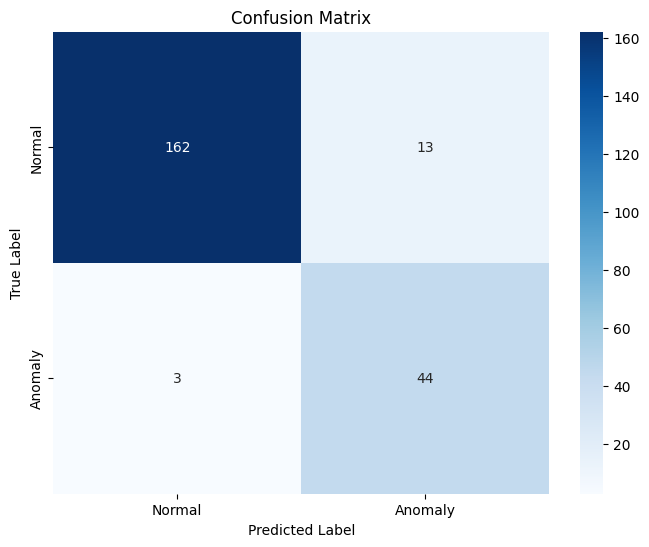

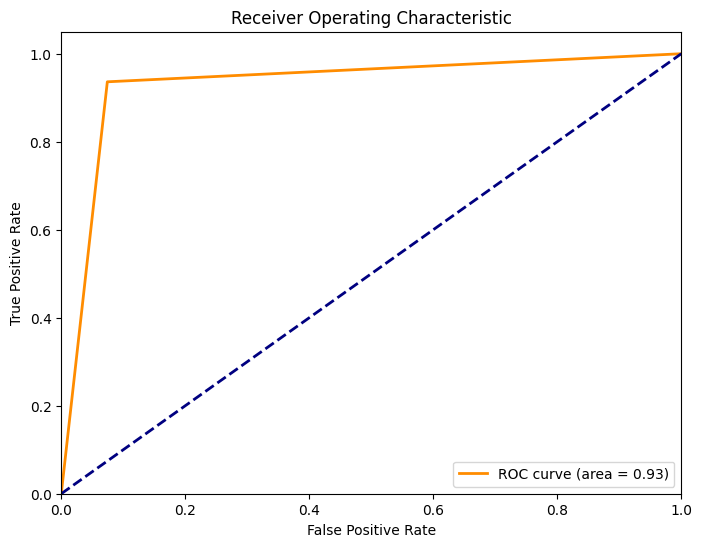

In [13]:
# So now we train the final model of the meritocratic voting model with the best hyperparameters
optimized_params = {
    'knn_n_neighbors_diff': 5.0, 
    'knn_n_neighbors_st': 2.0, 
    'n_1': 96.0, 'n_2': 72.0, 
    'n_3': 93.0, 
    'rf_max_depth_diff': 13.0, 
    'rf_max_depth_st': 26.0, 
    'rf_n_estimators_diff': 55.0, 
    'rf_n_estimators_st': 160.0, 
    'threshold': 0.2100943792137429, 
    'w_knn_diff': 0.39829612038288054, 
    'w_knn_st': 0.16003959839770482, 
    'w_rf_diff': 0.10500756712980036, 
    'w_rf_st': 0.13777976867502334, 
    'w_xg_dff': 0.15263204182449208, 
    'xgb_learning_rate_diff': 0.08349476815489305, 
    'xgb_learning_rate_st': 0.0854297577469351, 
    'xgb_max_depth_diff': 5.0, 
    'xgb_max_depth_st': 9.0, 
    'xgb_subsample_diff': 0.9370555692770547, 
    'xgb_subsample_st': 0.5008129368391105
    }

params = optimized_params

# Split the dataset into training and testing sets to evaluate the final model with meritocratic voting model
Xs_train, Xs_test, X_train, X_test, y_train, y_test = train_test_split(
            succ_data, 
            stationary_processes, 
            flag, 
            test_size=0.2, 
            stratify=flag, 
            random_state=79
        )

rf_classifier_diff = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_diff']),
            max_depth=int(params['rf_max_depth_diff']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )

rf_classifier_diff.fit(Xs_train, y_train)
rf_pred_test_diff = rf_classifier_diff.predict(Xs_test)
        
rf_classifier_stationarity = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_st']),
            max_depth=int(params['rf_max_depth_st']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )
rf_classifier_stationarity.fit(X_train, y_train)
rf_pred_test_st = rf_classifier_stationarity.predict(X_test)
        
        
xgb_diff = XGBClassifier(
            learning_rate=params['xgb_learning_rate_diff'],
            max_depth=int(params['xgb_max_depth_diff']),
            subsample=params['xgb_subsample_diff']
        )
xgb_diff.fit(Xs_train, y_train)
xgb_pred_test_diff = xgb_diff.predict(Xs_test)
        
xgb_st = XGBClassifier(
            learning_rate=params['xgb_learning_rate_st'],
            max_depth=int(params['xgb_max_depth_st']),
            subsample=params['xgb_subsample_st']
        )
xgb_st.fit(X_train, y_train)
xgb_pred_test_st = xgb_st.predict(X_test)
        

knn_diff = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_diff']))
knn_diff.fit(Xs_train, y_train)
knn_pred_test_diff = knn_diff.predict(Xs_test)
        
knn_st = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_st']))
knn_st.fit(X_train, y_train)
knn_pred_test_st = knn_st.predict(X_test)

sum_weights =  params['w_rf_diff'] + params['w_rf_st'] + params['w_knn_diff'] + params['w_knn_st'] + params['w_xg_dff'] 
weighted_pred = rf_pred_test_diff*params['w_rf_diff'] + rf_pred_test_st*params['w_rf_st'] + knn_pred_test_diff*params['w_knn_diff'] + knn_pred_test_st*params['w_knn_st'] + xgb_pred_test_diff*params['w_xg_dff'] + xgb_pred_test_st*(1-sum_weights)


final_test_preds = np.where(weighted_pred > optimized_params['threshold'], 1, 0)

# Calculate performance metrics for this window
acc = accuracy_score(y_test, final_test_preds)
f1 = f1_score(y_test, final_test_preds)
precision = precision_score(y_test, final_test_preds)
recall = recall_score(y_test, final_test_preds)

conf_matrix = confusion_matrix(y_test, final_test_preds)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, final_test_preds)
roc_auc = auc(fpr, tpr)


print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:",f1 )
print("ROC AUC:", roc_auc)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
# This is with the democratic voting model
def objective(params):

    # Selecting features based on the parameters
    n_1 = int(params['n_1'])
    n_2 = int(params['n_2'])
    n_3 = int(params['n_3'])
    stationary_processes_selected = stationary_processes.iloc[:, :n_1]
    succ_data_selected = succ_data.iloc[:, :n_2]
    combined_data_selected = combined_data.iloc[:, :n_3]

    # Determine the total number of samples and set up windowing for training/testing
    total_samples = stationary_processes_selected.shape[0]
    window_size = int(total_samples * 0.5)  # 20% of data as window size
    step_size = 10  # Step size can be adjusted as needed for overlap or window progression

    f1_scores = []

    for start in range(0, total_samples - window_size, step_size):
        end = start + window_size
        if end > total_samples:
            break

        # Split the dataset into training and testing sets
        Xs_train, Xs_test, X_train, X_test, y_train, y_test = train_test_split(
            succ_data_selected[start:end],
            stationary_processes_selected[start:end],
            flag[start:end], 
            test_size=0.2, 
            stratify=flag[start:end], 
            random_state=79
            )


        # random forest with diff_time e stationarity
        rf_classifier_diff = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_diff']),
            max_depth=int(params['rf_max_depth_diff']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )
        rf_classifier_diff.fit(Xs_train, y_train)
        rf_pred_test_diff = rf_classifier_diff.predict(Xs_test)
        
        rf_classifier_stationarity = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_st']),
            max_depth=int(params['rf_max_depth_st']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )
        rf_classifier_stationarity.fit(X_train, y_train)
        rf_pred_test_st = rf_classifier_stationarity.predict(X_test)
        
        # xgb with diff_time e stationarity
        xgb_diff = XGBClassifier(
            learning_rate=params['xgb_learning_rate_diff'],
            max_depth=int(params['xgb_max_depth_diff']),
            subsample=params['xgb_subsample_diff']
        )
        xgb_diff.fit(Xs_train, y_train)
        xgb_pred_test_diff = xgb_diff.predict(Xs_test)
        
        xgb_st = XGBClassifier(
            learning_rate=params['xgb_learning_rate_st'],
            max_depth=int(params['xgb_max_depth_st']),
            subsample=params['xgb_subsample_st']
        )
        xgb_st.fit(X_train, y_train)
        xgb_pred_test_st = xgb_st.predict(X_test)
        
        # knn with diff_time e stationarity

        knn_diff = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_diff']))
        knn_diff.fit(Xs_train, y_train)
        knn_pred_test_diff = knn_diff.predict(Xs_test)
        
        knn_st = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_st']))
        knn_st.fit(X_train, y_train)
        knn_pred_test_st = knn_st.predict(X_test)
        
        test_preds = np.column_stack((rf_pred_test_diff, knn_pred_test_diff, xgb_pred_test_diff, rf_pred_test_st, knn_pred_test_st, xgb_pred_test_st))
        final_test_preds = np.where(np.sum(test_preds, axis=1) > params['count'], 1, 0)

        # Calculate F1 score for this window
        f1 = f1_score(y_test, final_test_preds)
        f1_scores.append(f1)

    # Calculate the average F1 score across all windows
    mean_f1 = np.mean(f1_scores)
    return {'loss': -mean_f1, 'status': STATUS_OK}


In [15]:
space = {
    'count': hp.quniform('count', 1, 3, 1),
    'n_1': hp.quniform('n_1', 10, 100, 1),
    'n_2': hp.quniform('n_2', 50, 300, 1),
    'n_3': hp.quniform('n_3', 10, 100, 1),
    'threshold': hp.uniform('threshold', 0.1, 0.9),
    'w_rf_diff': hp.uniform('w_rf_diff', 0.1, 0.9),
    'w_rf_st': hp.uniform('w_rf_st', 0.1, 0.9),
    'w_knn_diff': hp.uniform('w_knn_diff', 0.1, 0.9),
    'w_knn_st': hp.uniform('w_knn_st', 0.1, 0.9),
    'w_xg_dff': hp.uniform('w_xg_dff', 0.1, 0.9),
    'rf_n_estimators_diff': hp.quniform('rf_n_estimators_diff', 50, 200, 5),
    'rf_max_depth_diff': hp.quniform('rf_max_depth_diff', 5, 30, 1),
    'rf_n_estimators_st': hp.quniform('rf_n_estimators_st', 50, 200, 5),
    'rf_max_depth_st': hp.quniform('rf_max_depth_st', 5, 30, 1),
    'xgb_learning_rate_diff': hp.uniform('xgb_learning_rate_diff', 0.01, 0.3),
    'xgb_max_depth_diff': hp.quniform('xgb_max_depth_diff', 3, 10, 1),
    'xgb_subsample_diff': hp.uniform('xgb_subsample_diff', 0.5, 1.0),
    'xgb_learning_rate_st': hp.uniform('xgb_learning_rate_st', 0.01, 0.3),
    'xgb_max_depth_st': hp.quniform('xgb_max_depth_st', 3, 10, 1),
    'xgb_subsample_st': hp.uniform('xgb_subsample_st', 0.5, 1.0),
    'knn_n_neighbors_diff': hp.quniform('knn_n_neighbors_diff', 1, 20, 1),
    'knn_n_neighbors_st': hp.quniform('knn_n_neighbors_st', 1, 20, 1)
}

if training_models:
    # Run the optimizer
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
    print("Best hyperparameters:", best)

Accuracy: 0.954954954954955
Precision: 0.8627450980392157
Recall: 0.9361702127659575
F1-score: 0.8979591836734694
ROC AUC: 0.9480851063829787


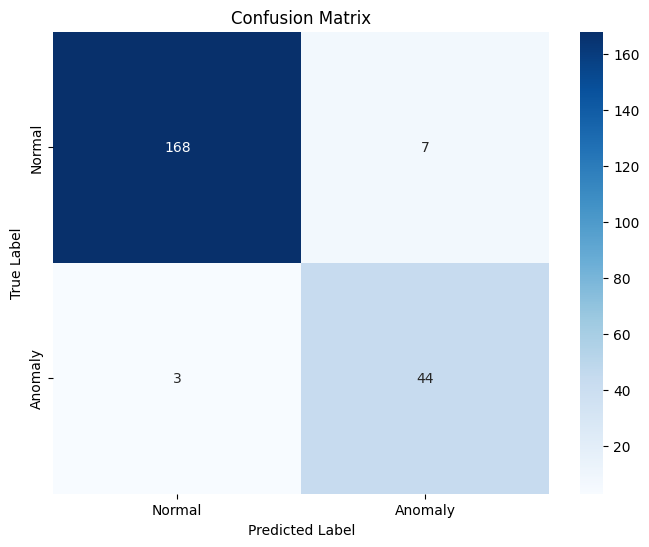

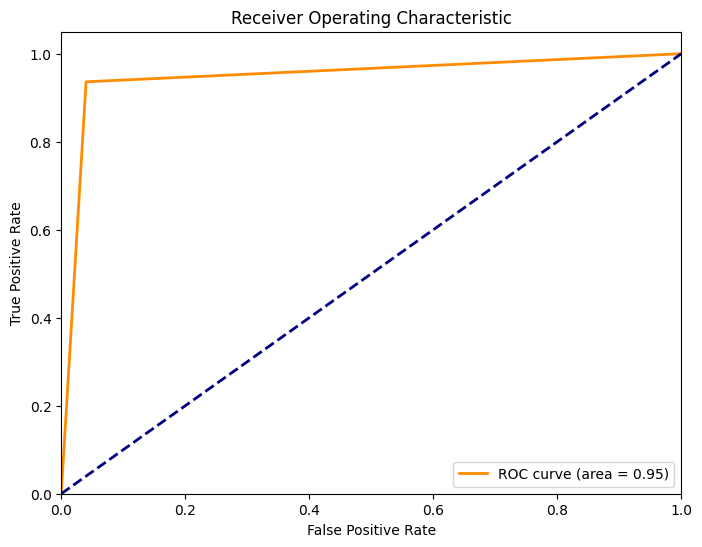

In [17]:
# So now we train the final model of the democratic voting model with the best hyperparameters
optimized_params = {
    'count': 1.0, 
    'knn_n_neighbors_diff': 7.0, 
    'knn_n_neighbors_st': 4.0, 
    'n_1': 85.0, 
    'n_2': 85.0, 
    'n_3': 15.0, 
    'rf_max_depth_diff': 9.0, 
    'rf_max_depth_st': 19.0, 
    'rf_n_estimators_diff': 80.0, 
    'rf_n_estimators_st': 80.0, 
    'threshold': 0.16413358875313344, 
    'w_knn_diff': 0.374316392886494, 
    'w_knn_st': 0.4245739891176323, 
    'w_rf_diff': 0.8492195534092585, 
    'w_rf_st': 0.6565821126667847, 
    'w_xg_dff': 0.6125350525659878, 
    'xgb_learning_rate_diff': 0.1101443898810552, 
    'xgb_learning_rate_st': 0.19804243711590508, 
    'xgb_max_depth_diff': 5.0, 
    'xgb_max_depth_st': 3.0, 
    'xgb_subsample_diff': 0.5972922538885599, 
    'xgb_subsample_st': 0.7407294720792603
}

params = optimized_params

# Split the dataset into training and testing sets
Xs_train, Xs_test, X_train, X_test, y_train, y_test = train_test_split(
            succ_data, 
            stationary_processes, 
            flag, 
            test_size=0.2, 
            stratify=flag, 
            random_state=79
        )

# random forest with diff_time e stationarity
rf_classifier_diff = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_diff']),
            max_depth=int(params['rf_max_depth_diff']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )

rf_classifier_diff.fit(Xs_train, y_train)
rf_pred_test_diff = rf_classifier_diff.predict(Xs_test)
        
rf_classifier_stationarity = RandomForestClassifier(
            n_estimators=int(params['rf_n_estimators_st']),
            max_depth=int(params['rf_max_depth_st']),
            class_weight={0: 1 - 0.2133, 1: 0.2133}
        )
rf_classifier_stationarity.fit(X_train, y_train)
rf_pred_test_st = rf_classifier_stationarity.predict(X_test)
        
# xgb with diff_time e stationarity
xgb_diff = XGBClassifier(
            learning_rate=params['xgb_learning_rate_diff'],
            max_depth=int(params['xgb_max_depth_diff']),
            subsample=params['xgb_subsample_diff']
        )
xgb_diff.fit(Xs_train, y_train)
xgb_pred_test_diff = xgb_diff.predict(Xs_test)
        
xgb_st = XGBClassifier(
            learning_rate=params['xgb_learning_rate_st'],
            max_depth=int(params['xgb_max_depth_st']),
            subsample=params['xgb_subsample_st']
        )
xgb_st.fit(X_train, y_train)
xgb_pred_test_st = xgb_st.predict(X_test)
        
# knn with diff_time e stationarity
knn_diff = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_diff']))
knn_diff.fit(Xs_train, y_train)
knn_pred_test_diff = knn_diff.predict(Xs_test)
        
knn_st = KNeighborsClassifier(n_neighbors=int(params['knn_n_neighbors_st']))
knn_st.fit(X_train, y_train)
knn_pred_test_st = knn_st.predict(X_test)

test_preds = np.column_stack((rf_pred_test_diff, knn_pred_test_diff, xgb_pred_test_diff, rf_pred_test_st, knn_pred_test_st, xgb_pred_test_st))
final_test_preds = np.where(np.sum(test_preds, axis=1) > params['count'], 1, 0)

# Calculate performance metrics for this window
acc = accuracy_score(y_test, final_test_preds)
f1 = f1_score(y_test, final_test_preds)
precision = precision_score(y_test, final_test_preds)
recall = recall_score(y_test, final_test_preds)

conf_matrix = confusion_matrix(y_test, final_test_preds)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, final_test_preds)
roc_auc = auc(fpr, tpr)


print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:",f1 )
print("ROC AUC:", roc_auc)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()